##Data

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data_dir = '/content/drive/MyDrive/CustomDS/3Class/train'
validation_data_dir = '/content/drive/MyDrive/CustomDS/3Class/validation'
# test_data_dir = '/content/drive/MyDrive/Project/PROJECT-1/Data SetBin/Final-data/test'
img_height = 256
img_width = 256
batch_size = 32
# color_mode = 'grayscale'
class_mode = 'categorical'

In [ ]:
filepaths = []
labels = []

for class_name in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for file in os.listdir(class_path):
        filepaths.append(os.path.join(class_path, file))
        labels.append(class_name)

df = pd.DataFrame({'filename': filepaths, 'class': labels})

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['class'],
    random_state=42
)


Non-Augmented

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

Found 131 validated image filenames belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 33 validated image filenames belonging to 3 classes.


Augmented

In [ ]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)


Found 131 validated image filenames belonging to 3 classes.


##LeNet-5

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,AveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#LeNet 5 model
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(img_height,img_width,3)),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

Augmented

In [ ]:
checkpoint = ModelCheckpoint('lenet_with_data_aug.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(train_generator_augmented, epochs=50, validation_data=valid_generator,callbacks=[checkpoint])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2857 - auc: 0.4728 - loss: 1.2205 - precision: 0.2247 - recall: 0.1123

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.26667, saving model to lenet_with_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.2928 - auc: 0.4785 - loss: 1.2211 - precision: 0.2391 - recall: 0.1178 - val_accuracy: 0.2667 - val_auc: 0.5433 - val_loss: 1.0808 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4055 - auc: 0.5901 - loss: 1.0767 - precision: 0.3672 - recall: 0.0334
Epoch 2: val_accuracy improved from 0.26667 to 0.33333, saving model to lenet_with_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3990 - auc: 0.5910 - loss: 1.0758 - precision: 0.4342 - recall: 0.0405 - val_accuracy: 0.3333 - val_auc: 0.5611 - val_loss: 1.0920 - val_precision: 0.6000 - val_recall: 0.2000
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4303 - auc: 0.6692 - loss: 1.0308 - precision: 0.5614 - recall: 0.1655
Epoch 3: val_accuracy did not improve from 0.33333
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 

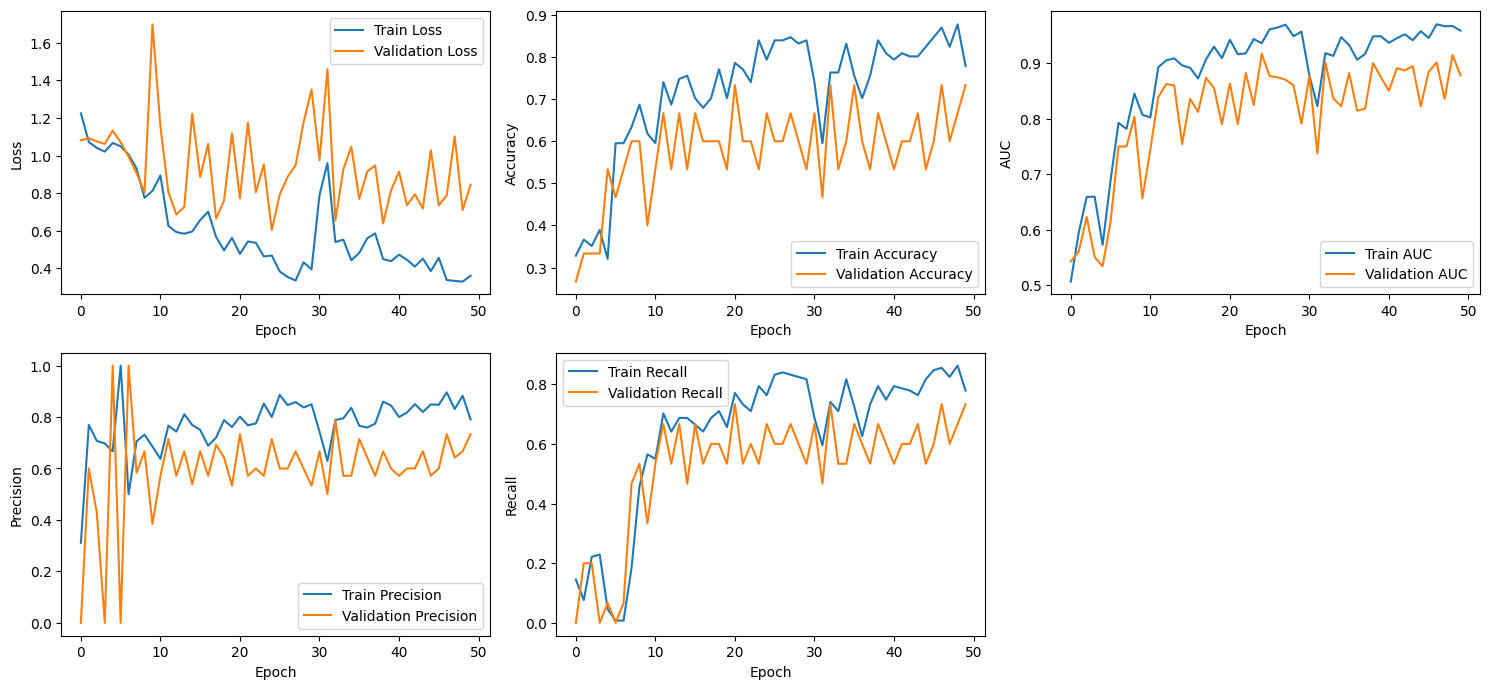

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot Train Loss vs Validation Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Train Accuracy vs Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Train AUC vs Validation AUC
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot Train Precision vs Validation Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Train Recall vs Validation Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


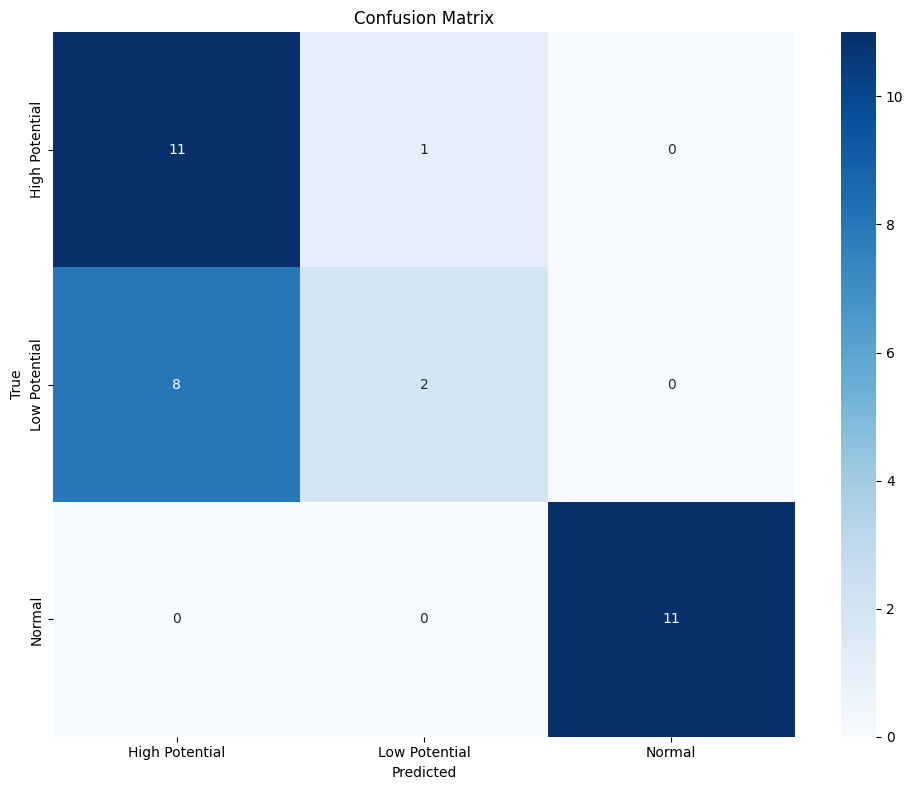

Overall Accuracy: 0.7273

Classification Report:
                precision    recall  f1-score   support

High Potential       0.58      0.92      0.71        12
 Low Potential       0.67      0.20      0.31        10
        Normal       1.00      1.00      1.00        11

      accuracy                           0.73        33
     macro avg       0.75      0.71      0.67        33
  weighted avg       0.75      0.73      0.68        33



In [ ]:
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Non-Augmented

In [ ]:
checkpoint = ModelCheckpoint('lenet_without_data_aug.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(train_generator, epochs=50, validation_data=valid_generator,callbacks=[checkpoint])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8458 - auc: 0.9671 - loss: 0.3377 - precision: 0.8474 - recall: 0.8361
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to lenet_without_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8460 - auc: 0.9671 - loss: 0.3367 - precision: 0.8483 - recall: 0.8367 - val_accuracy: 0.8000 - val_auc: 0.9444 - val_loss: 0.4852 - val_precision: 0.8571 - val_recall: 0.8000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9393 - auc: 0.9900 - loss: 0.1914 - precision: 0.9453 - recall: 0.9393
Epoch 2: val_accuracy did not improve from 0.80000
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9329 - auc: 0.9887 - loss: 0.2004 - precision: 0.9391 - recall: 0.9329 - val_accuracy: 0.6667 - val_auc: 0.8933 - val_loss: 0.6666 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9409 - auc: 0.9936 - loss: 0.1614 - precision: 0.9401 - recall: 0.9264
Ep

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot Train Loss vs Validation Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Train Accuracy vs Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Train AUC vs Validation AUC
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot Train Precision vs Validation Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Train Recall vs Validation Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

##Vision-Transformer



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
class ClassTokenLayer(layers.Layer):
    def __init__(self, projection_dim):
        super().__init__()
        self.projection_dim = projection_dim
        self.class_token = tf.Variable(tf.zeros([1, 1, projection_dim]))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        class_tokens = tf.broadcast_to(self.class_token, [batch_size, 1, self.projection_dim])
        return layers.Concatenate(axis=1)([class_tokens, inputs])
def VisionTransformer(input_shape, patch_size, projection_dim, num_heads, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(projection_dim, patch_size, patch_size)(inputs)
    num_patches = x.shape[1] * x.shape[2]
    x = layers.Reshape((num_patches, projection_dim))(x)
    x = ClassTokenLayer(projection_dim)(x)
    positions = tf.range(start=0, limit=num_patches + 1, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)(positions)
    pos_embed = tf.expand_dims(pos_embed, axis=0)
    x = x + pos_embed

    # Transformer blocks
    for _ in range(6):
        x1 = layers.LayerNormalization()(x)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim
        )(x1, x1)
        x = layers.Add()([x, attention_output])

        x2 = layers.LayerNormalization()(x)
        x2 = layers.Dense(projection_dim * 2, activation="gelu")(x2)
        x2 = layers.Dense(projection_dim)(x2)
        x = layers.Add()([x, x2])

    x = layers.LayerNormalization()(x)
    x = x[:, 0]  # Extract class token
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
input_shape = (img_height, img_width, 3)
patch_size = 16
projection_dim = 128
num_heads = 8
num_classes = len(train_generator_augmented.class_indices)
epochs = 23
model = VisionTransformer(
    input_shape=input_shape,
    patch_size=patch_size,
    projection_dim=projection_dim,
    num_heads=num_heads,
    num_classes=num_classes
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy",
              tf.keras.metrics.AUC(name='auc'),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
)

Augmented

In [ ]:
# history = model.fit(
#     train_generator_augmented,
#     validation_data=valid_generator,
#     epochs=epochs
# )
# model.save("vision_transformer_with_data_aug.keras")
checkpoint = ModelCheckpoint('vision_transformer_with_data_aug.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(train_generator_augmented, epochs=50, validation_data=valid_generator,callbacks=[checkpoint])

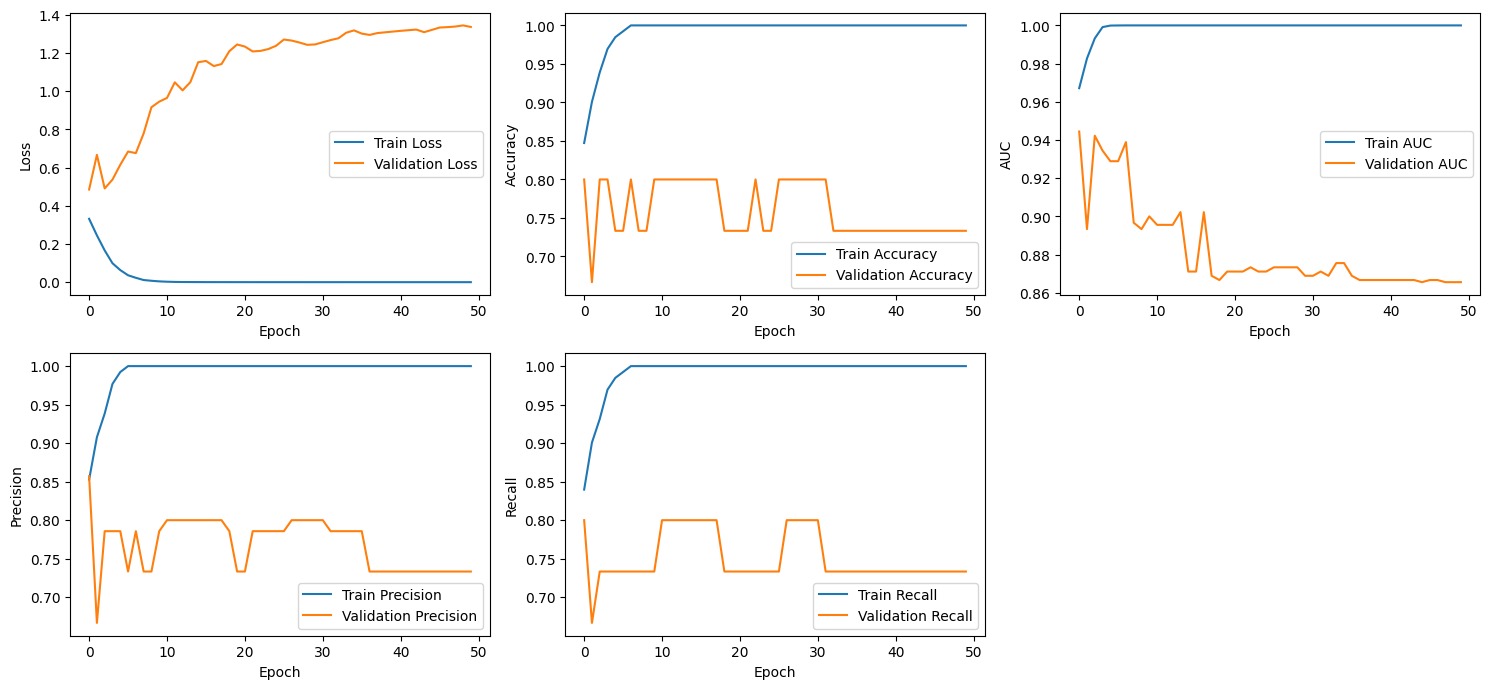

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot Train Loss vs Validation Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Train Accuracy vs Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Train AUC vs Validation AUC
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot Train Precision vs Validation Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Train Recall vs Validation Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step 


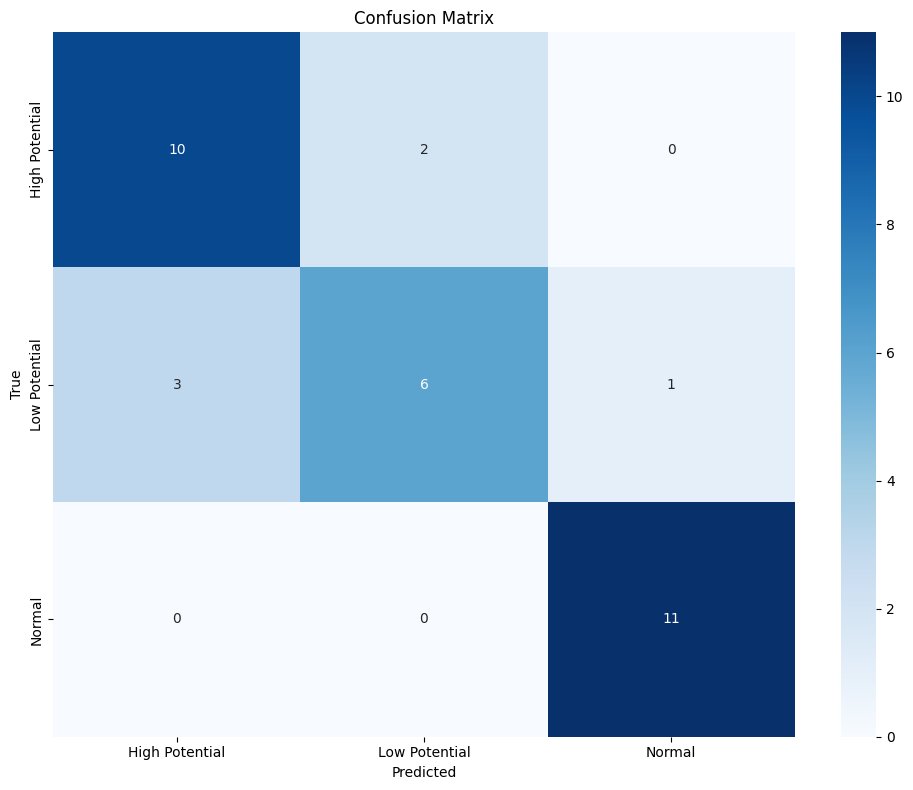

Overall Accuracy: 0.8182

Classification Report:
                precision    recall  f1-score   support

High Potential       0.77      0.83      0.80        12
 Low Potential       0.75      0.60      0.67        10
        Normal       0.92      1.00      0.96        11

      accuracy                           0.82        33
     macro avg       0.81      0.81      0.81        33
  weighted avg       0.81      0.82      0.81        33



In [ ]:
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Non-Augmented

In [ ]:
# history = model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     epochs=epochs
# )
# model.save("vision_transformer_without_data_aug.keras")
checkpoint = ModelCheckpoint('vision_transformer_without_data_aug.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(train_generator, epochs=50, validation_data=valid_generator,callbacks=[checkpoint])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.3758e-05 - precision: 1.0000 - recall: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to vision_transformer_without_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.4308e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7333 - val_auc: 0.8656 - val_loss: 1.3455 - val_precision: 0.7333 - val_recall: 0.7333
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.3990e-05 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_accuracy did not improve from 0.73333
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.4356e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7333 - val_auc: 0.8667 - val_loss: 1.3565 - val_precision: 0.7333 - val_recall: 0.7333
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.3358e-05 - prec

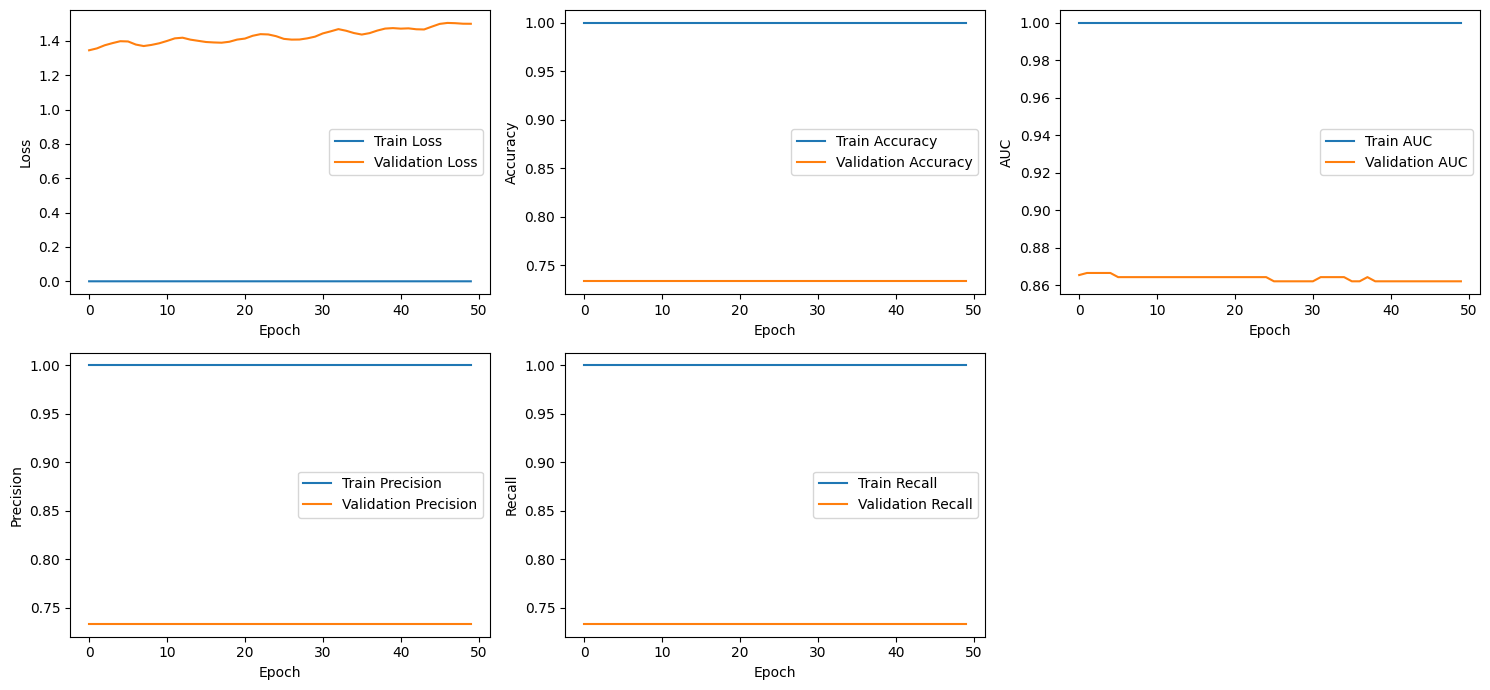

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot Train Loss vs Validation Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Train Accuracy vs Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Train AUC vs Validation AUC
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot Train Precision vs Validation Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Train Recall vs Validation Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step 


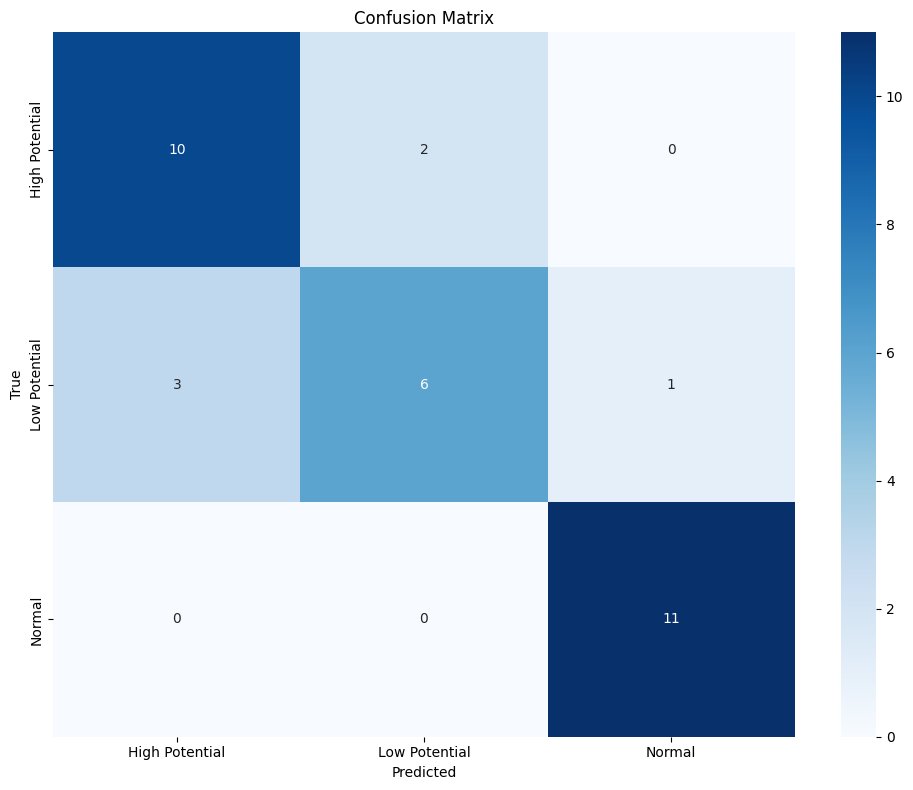

Overall Accuracy: 0.8182

Classification Report:
                precision    recall  f1-score   support

High Potential       0.77      0.83      0.80        12
 Low Potential       0.75      0.60      0.67        10
        Normal       0.92      1.00      0.96        11

      accuracy                           0.82        33
     macro avg       0.81      0.81      0.81        33
  weighted avg       0.81      0.82      0.81        33



In [ ]:
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

##3-Layer CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import seaborn as sns

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(img_height,img_width,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 200)            │    23,040,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,273,635 (88.78 MB)

 Trainable params: 23,273,635 (88.78 MB)

 Non-trainable params: 0 (0.00 B)

With Data Augmentation

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('3_layer_cnn_with_data_aug.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(train_generator_augmented, epochs=50, validation_data=valid_generator, callbacks=[checkpoint])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6007 - auc: 0.7268 - loss: 0.9898 - precision: 0.3667 - recall: 0.0193
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to 3_layer_cnn_with_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.5985 - auc: 0.7284 - loss: 0.9860 - precision: 0.4444 - recall: 0.0288 - val_accuracy: 0.4000 - val_auc: 0.6267 - val_loss: 1.0598 - val_precision: 0.5455 - val_recall: 0.4000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4203 - auc: 0.5790 - loss: 1.0630 - precision: 0.6176 - recall: 0.0773 
Epoch 2: val_accuracy improved from 0.40000 to 0.60000, saving model to 3_layer_cnn_with_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.4482 - auc: 0.6061 - loss: 1.0497 - precision: 0.6510 - recall: 0.0759 - val_accuracy: 0.6000 - val_auc: 0.7533 - val_loss: 0.9645 - val_precision: 1.0000 - val_recall: 0.1333
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6152 - auc: 0

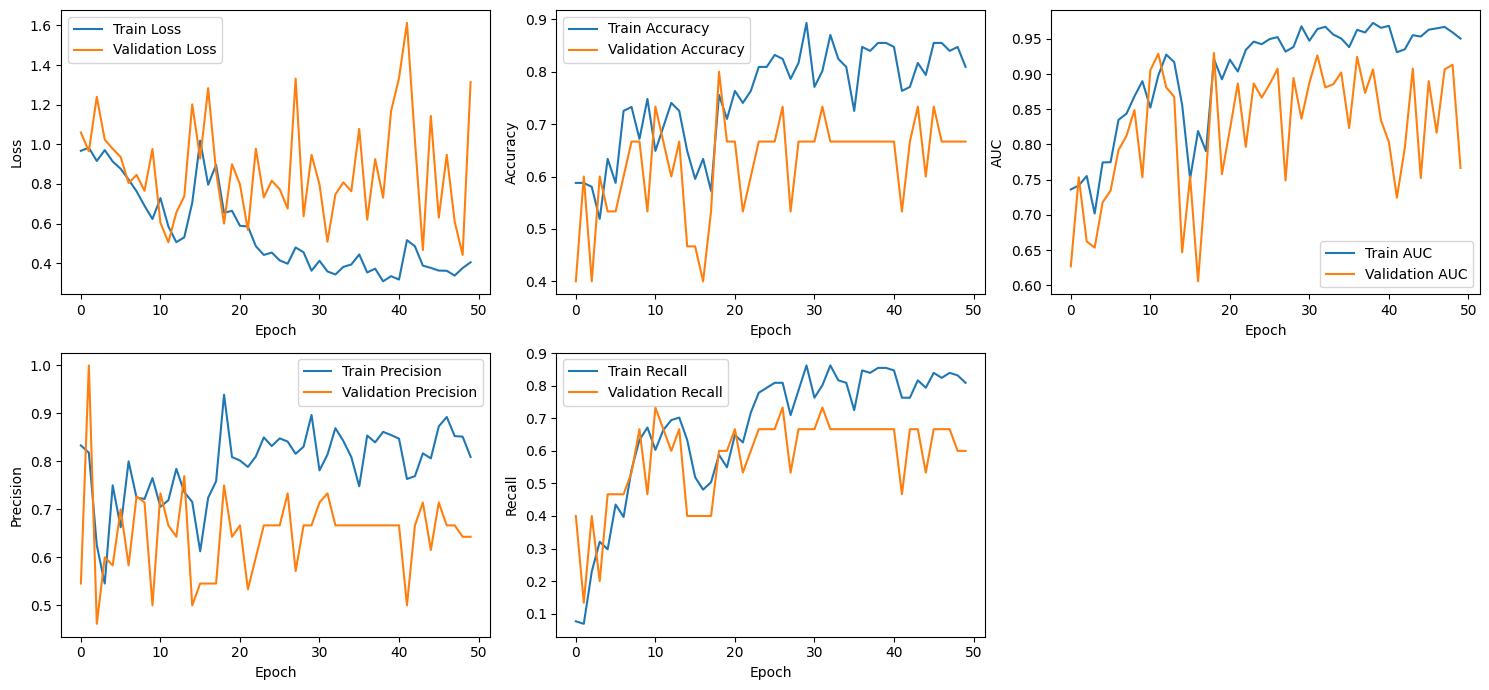

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot Train Loss vs Validation Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Train Accuracy vs Val+idation Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Train AUC vs Validation AUC
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot Train Precision vs Validation Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Train Recall vs Validation Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step


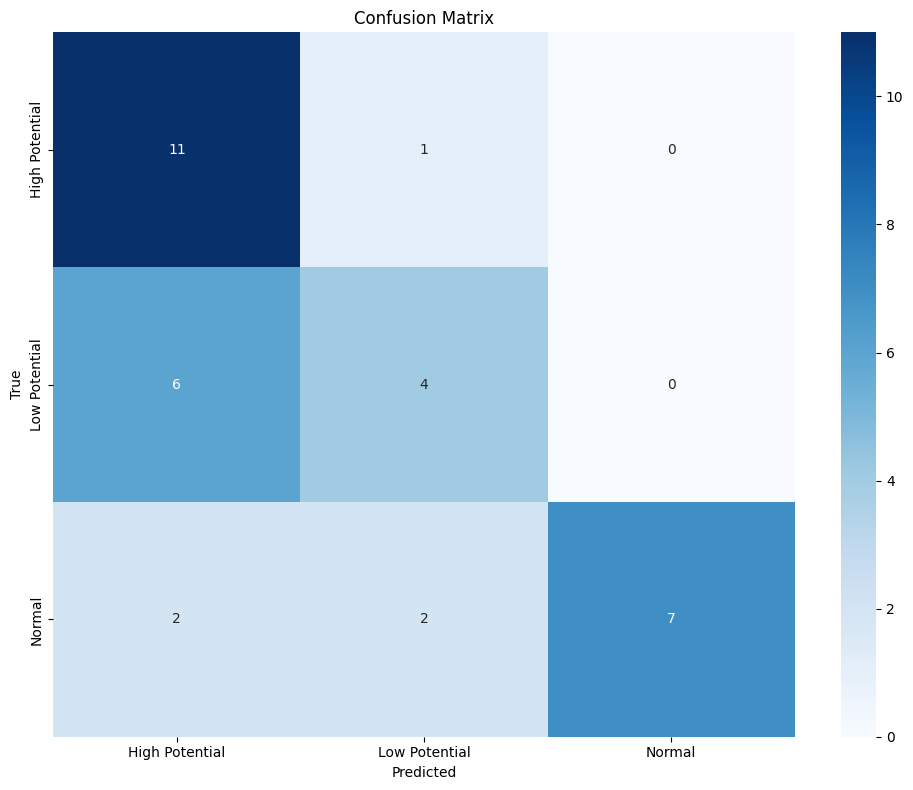

Overall Accuracy: 0.6667

Classification Report:
                precision    recall  f1-score   support

High Potential       0.58      0.92      0.71        12
 Low Potential       0.57      0.40      0.47        10
        Normal       1.00      0.64      0.78        11

      accuracy                           0.67        33
     macro avg       0.72      0.65      0.65        33
  weighted avg       0.72      0.67      0.66        33



In [ ]:
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Without Data-Augmentation


In [ ]:
# history = model.fit(train_generator, epochs=50, validation_data=valid_generator)
# model.save('3_layer_cnn_without_data_aug.keras')
checkpoint = ModelCheckpoint('3_layer_cnn_without_data_aug.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(train_generator, epochs=50, validation_data=valid_generator,callbacks=[checkpoint])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7397 - auc: 0.8788 - loss: 0.8125 - precision: 0.7586 - recall: 0.7382
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to 3_layer_cnn_without_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.7437 - auc: 0.8840 - loss: 0.7822 - precision: 0.7621 - recall: 0.7411 - val_accuracy: 0.6667 - val_auc: 0.8900 - val_loss: 0.7012 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8115 - auc: 0.9242 - loss: 0.5414 - precision: 0.8082 - recall: 0.7965
Epoch 2: val_accuracy improved from 0.66667 to 0.73333, saving model to 3_layer_cnn_without_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.8188 - auc: 0.9292 - loss: 0.5192 - precision: 0.8158 - recall: 0.8050 - val_accuracy: 0.7333 - val_auc: 0.9111 - val_loss: 0.6410 - val_precision: 0.7333 - val_recall: 0.7333
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8125 - au

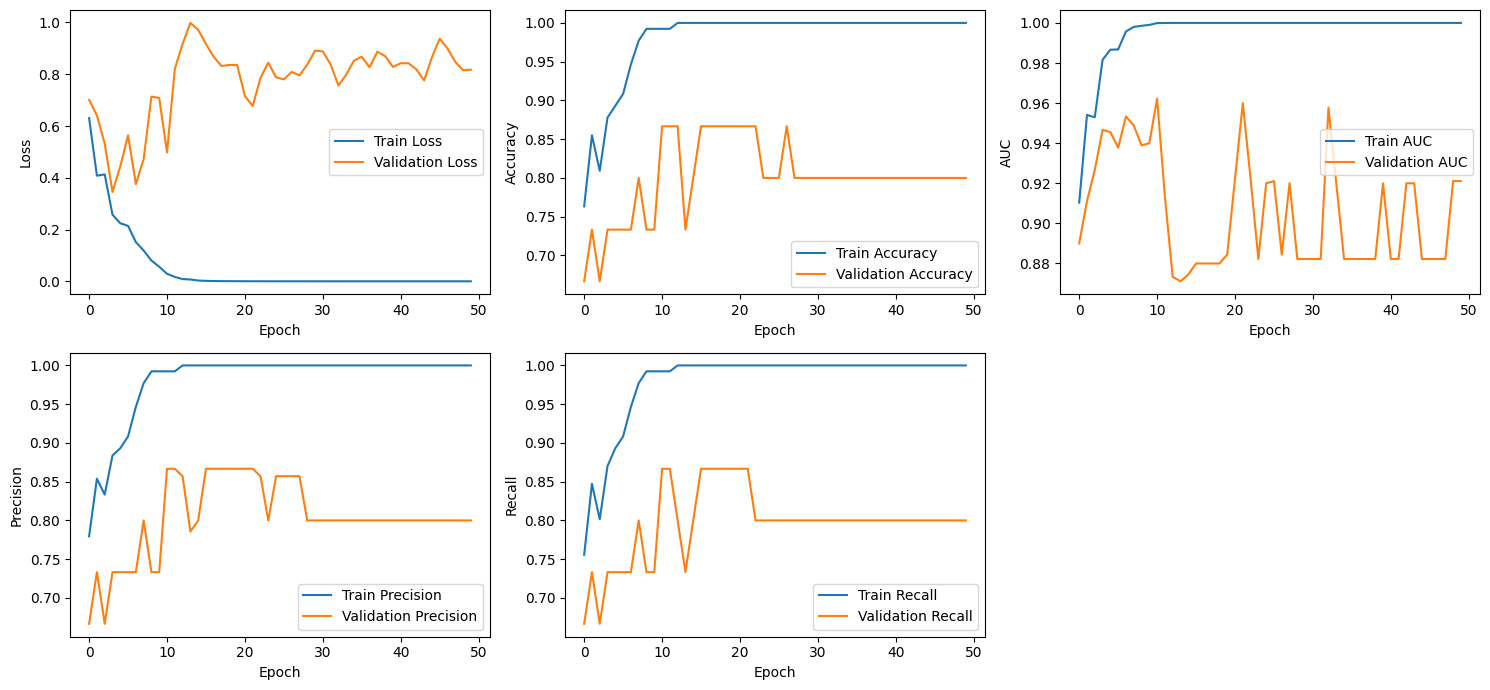

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot Train Loss vs Validation Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Train Accuracy vs Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Train AUC vs Validation AUC
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot Train Precision vs Validation Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Train Recall vs Validation Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step


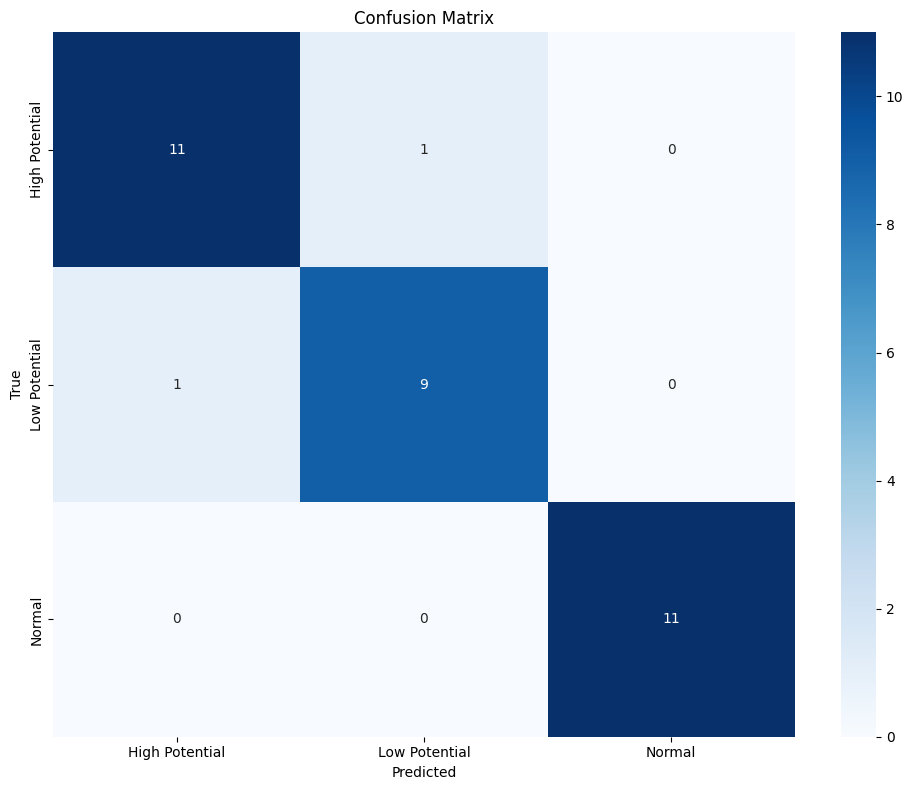

Overall Accuracy: 0.9394

Classification Report:
                precision    recall  f1-score   support

High Potential       0.92      0.92      0.92        12
 Low Potential       0.90      0.90      0.90        10
        Normal       1.00      1.00      1.00        11

      accuracy                           0.94        33
     macro avg       0.94      0.94      0.94        33
  weighted avg       0.94      0.94      0.94        33



In [ ]:
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

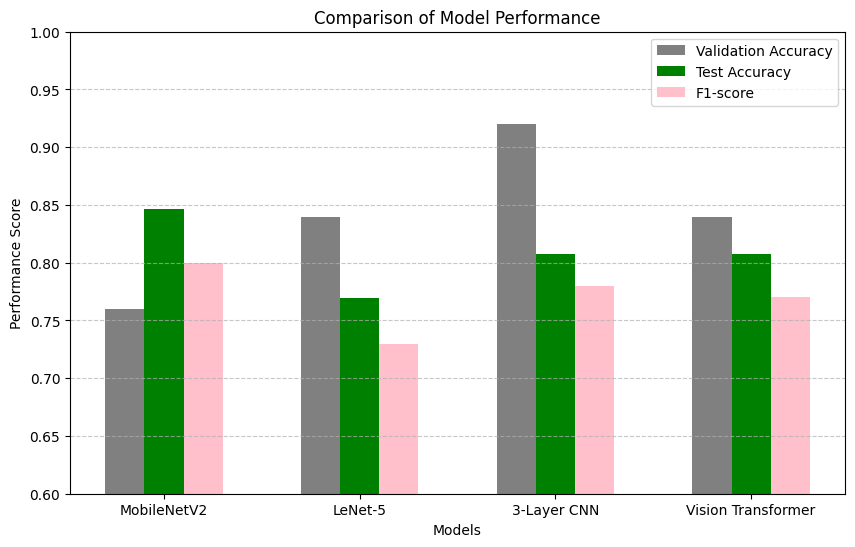

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ["MobileNetV2", "LeNet-5", "3-Layer CNN", "Vision Transformer"]

# Performance metrics
val_acc = [0.76, 0.84, 0.92, 0.84]  # Validation Accuracy
test_acc = [0.8462, 0.7692, 0.8077, 0.8077]  # Test Accuracy
f1_score = [0.80, 0.73, 0.78, 0.77]  # F1-score

# Bar width
bar_width = 0.2
x = np.arange(len(models))

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, val_acc, width=bar_width, label="Validation Accuracy", color="gray")
plt.bar(x, test_acc, width=bar_width, label="Test Accuracy", color="green")
plt.bar(x + bar_width, f1_score, width=bar_width, label="F1-score", color="pink")

# Labels and formatting
plt.xlabel("Models")
plt.ylabel("Performance Score")
plt.title("Comparison of Model Performance")
plt.xticks(x, models)
plt.legend()
plt.ylim(0.6, 1.0)  # Set y-axis limits
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


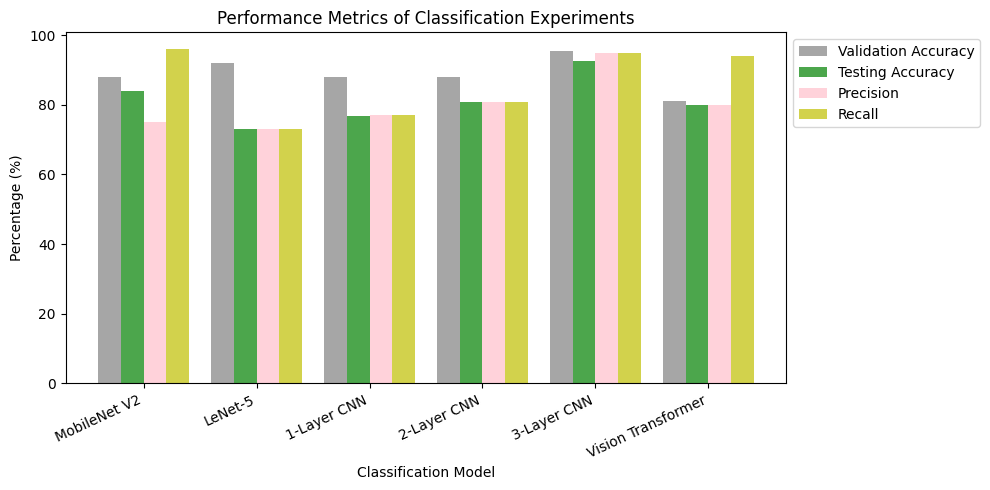

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the table
models = ["MobileNet V2", "LeNet-5", "1-Layer CNN", "2-Layer CNN", "3-Layer CNN", "Vision Transformer"]
validation_acc = [88, 92, 88, 88, 95.57, 81.11]
testing_acc = [84, 73.08, 76.92, 80.76, 92.5, 80.01]
precision = [75, 73, 77, 80.76, 95, 80]
recall = [96, 73, 77, 80.76, 95, 94]

# Bar width
bar_width = 0.2
x = np.arange(len(models))

# Creating the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars
ax.bar(x - 1.5 * bar_width, validation_acc, width=bar_width, label="Validation Accuracy", color='gray', alpha=0.7)
ax.bar(x - 0.5 * bar_width, testing_acc, width=bar_width, label="Testing Accuracy", color='g', alpha=0.7)
ax.bar(x + 0.5 * bar_width, precision, width=bar_width, label="Precision", color='pink', alpha=0.7)
ax.bar(x + 1.5 * bar_width, recall, width=bar_width, label="Recall", color='y', alpha=0.7)

# Labels and title
ax.set_xlabel("Classification Model")
ax.set_ylabel("Percentage (%)")
ax.set_title("Performance Metrics of Classification Experiments")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, ha="right")

# Move legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Adjust layout to fit legend
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, projection_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = layers.Dense(projection_dim)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return self.projection(patches)

class ClassToken(layers.Layer):
    def __init__(self, projection_dim):
        super().__init__()
        self.cls = self.add_weight(
            shape=(1, 1, projection_dim),
            initializer="zeros",
            trainable=True,
            name="cls_token"
        )

    def call(self, x):
        batch_size = tf.shape(x)[0]
        cls_tokens = tf.broadcast_to(self.cls, [batch_size, 1, x.shape[-1]])
        return tf.concat([cls_tokens, x], axis=1)

def SimpleVisionTransformer(input_shape, patch_size, projection_dim, num_heads, num_layers, mlp_dim, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Patch projection
    x = PatchEmbedding(patch_size, projection_dim)(inputs)

    # Static shape inference (safe)
    num_patches = x.shape[1]

    # Add class token
    x = ClassToken(projection_dim)(x)

    # Positional embedding
    positions = tf.range(start=0, limit=num_patches + 1, delta=1)
    pos_embedding_layer = layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)
    pos_embeddings = pos_embedding_layer(positions)
    x = x + pos_embeddings  # Broadcasting automatically handles batch dim

    # Transformer encoder blocks
    for _ in range(num_layers):
        # Self-attention
        residual = x
        x = layers.LayerNormalization()(x)
        x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
        x = layers.Add()([residual, x])

        # MLP
        residual = x
        x = layers.LayerNormalization()(x)
        x = layers.Dense(mlp_dim, activation="gelu")(x)
        x = layers.Dense(projection_dim)(x)
        x = layers.Add()([residual, x])

    x = layers.LayerNormalization()(x)
    cls_token_final = x[:, 0]  # Extract only class token
    outputs = layers.Dense(num_classes, activation="softmax")(cls_token_final)

    return keras.Model(inputs, outputs)



In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('3_layer_cnn_with_data_aug.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history = model.fit(train_generator_augmented, epochs=50, validation_data=valid_generator, callbacks=[checkpoint])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7318 - auc: 0.8898 - loss: 1.0610 - precision: 0.7318 - recall: 0.7318
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to 3_layer_cnn_with_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step - accuracy: 0.7396 - auc: 0.8942 - loss: 1.0155 - precision: 0.7396 - recall: 0.7396 - val_accuracy: 0.6667 - val_auc: 0.9367 - val_loss: 0.5371 - val_precision: 0.6667 - val_recall: 0.6667
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8425 - auc: 0.9333 - loss: 0.5634 - precision: 0.8422 - recall: 0.8410  
Epoch 2: val_accuracy improved from 0.66667 to 0.73333, saving model to 3_layer_cnn_with_data_aug.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 76s 9s/step - accuracy: 0.8395 - auc: 0.9317 - loss: 0.5746 - precision: 0.8390 - recall: 0.8369 - val_accuracy: 0.7333 - val_auc: 0.9556 - val_loss: 0.5017 - val_precision: 0.7333 - val_recall: 0.7333
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8270 - auc: 0